### Proyecto #4 - Mejora de modelo Serie de tiempo:
El principal desafío de este notebook es la extensión del modelo de serie de tiempo realizado en la entrega numero 3, realizada anteriormente. Este notebook asume la lectura del modelo de serie de tiempo realizado sobre el [dataset de trafico de AUSA (Argentina)](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa) para el año 2019, sobre la estacion ILLIA y partirá de esa base para mejorarlo y completarlo.  El principal desafío es llevar ese primer borrador de modelo básico, ya a un modelo mas terminado y profesional, con algunas correcciones pertinentes. 

### Mejores y desafíos a resolver: 
El modelo anterior fue realizado como una primera aproximación y montado sobre arrays de numpy `crudos` realizado de manera manual, sobre los cuales montamos los atributos principales y entrenamos un primer borrador de modelo con un `RandomForest` sin ningún tipo de biblioteca, ni depuración de variables o seleccion de atributos o embebido de variables extras que pudieran ayudar a la prediccion; por lo que en este trabajo realizaremos las mejoras pertinentes en ese sentido. 

### Lista de Modificaciones pendientes:
1. Agregaremos informacion externa al dataset, informacion categorica sobre fechas especiales `Feriados`, `Dias_de_Semana` y `Paro`, con el objetivo de mejorar la prediccion.
2. Realizaremos una depuracion, dejando las variables mas relevantes para el modelo y dejando espacio para nuevos atributos
3. Implementaremos Polinomios y PCA y ver su interaccion y resultados en performance.
4. Finalmente, productivizar e implementar un nuevo modelo, similar, utilizando la bibioteca `prophet` de facebook, de manera de hacer todo este proceso mucho mas acelerado, computacionalmente eficiente, escalable, e iterable para el modelado, comparando ventajas y desventajas y como desempeña en comparacion con el modelo anterior. 
______________________________

### 1.Preparacion Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [3]:
# Importado Data 
data_2019 = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2017.csv', sep =',')
# Consolidacion
dataset1 = pd.concat([data_2017, data_2018, data_2019])

In [53]:
# Filtro relevante
dataset = dataset1.query("forma_pago == 'EFECTIVO' & estacion == 'Illia'").copy()
# Defino Index; clase DateTime para Serie de tiempo
dataset.index = pd.to_datetime(dataset.fecha)
dataset = dataset.resample("D").sum().copy()

In [54]:
# Feriados; importo feriados sacados manualmente de Gobierno (innecesario hacer scrapping)
feriados17=['2017-01-01','2017-02-27','2017-02-28','2017-03-28','2017-04-02','2017-04-13','2017-04-14','2017-05-01','2017-06-17','2017-06-20','2017-07-09','2017-08-17','2017-10-12','2017-11-20','2017-12-08','2017-12-25']
feriados18=['2018-01-01','2018-02-12','2018-02-13','2018-03-24','2018-03-30','2018-04-02','2018-04-30','2018-05-01','2018-05-25','2018-06-17','2018-06-20','2018-07-09','2018-08-20','2018-10-15','2018-11-19','2018-12-08','2018-12-24','2018-12-25','2018-12-31']
feriados19=['2019-01-01','2019-03-04','2019-03-05','2019-03-24','2019-04-02','2019-04-18','2019-04-19','2019-05-01','2019-05-25','2019-06-17','2019-06-20','2019-07-08','2019-07-09','2019-08-17','2019-08-19','2019-10-12','2019-10-14','2019-11-18','2019-12-08','2019-12-25']

feriados = feriados17 + feriados18 + feriados19

### 2. Creacion de nuevas variables

In [55]:
# Creamos columna con info de feriados
dataset['fl_feriado'] = dataset.index.isin(feriados)
# casteo forzado a int, en caso que algun algoritmo en C/C++ no reconozca booleano
dataset.fl_feriado = dataset.fl_feriado.astype(int) 
dataset.drop(columns=['hora_inicio', 'hora_fin', 'periodo'], inplace=True)

In [56]:
# Creamos variables de dia de semana
dataset['dia'] = dataset.index.weekday.astype(int)

Aca podemos ver el resultado de las nuevas variables encodeadas; tanto `fl_feriado` y `dia`

In [57]:
dataset.head()

,cantidad_pasos,fl_feriado,dia
fecha,,,
2017-01-01,31183,1,6
2017-01-02,51568,0,0
2017-01-03,51093,0,1
2017-01-04,53332,0,2
2017-01-05,56486,0,3


Sin embargo necesitamos al dia tambien en formato dummie, lo transformamos con `pd.get_dummies(...)` y ya estamos listos para proceder con las nuevas variables y limpieza y seleccion de atributos:

In [58]:
# Creamos dummies para semana
dataset= pd.get_dummies(dataset, columns=['dia'] , prefix='dia')
dataset

,cantidad_pasos,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,
2017-01-01,31183,1,0,0,0,0,0,0,1
2017-01-02,51568,0,1,0,0,0,0,0,0
2017-01-03,51093,0,0,1,0,0,0,0,0
2017-01-04,53332,0,0,0,1,0,0,0,0
2017-01-05,56486,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2019-12-27,40182,0,0,0,0,0,1,0,0
2019-12-28,30681,0,0,0,0,0,0,1,0
2019-12-29,26259,0,0,0,0,0,0,0,1


### 3. Exploracion y reduccion de atributos anteriores

Segun lo que vimos en el modelo anterior, ciertos atributos (siempre `fechas`) eran mucho mas importantes que otros. Con un poco de limpieza e ingeniería de atriutos podemos empezar a encontrar ciertas mejoras que explotar, para hacer el modelo mas reducido, interpretable y preciso.   

Esto es lo que haremos ahora. Para comenzar, tengamos en cuenta que en el ultimo modelo encontramos el siguiente TOP 10 de atributos `t-n` mas importantes :

In [59]:
file = 'serie_tiempo_py3.sav'; modelo_cargado = pickle.load(open(file, 'rb'))
atributos = pd.DataFrame({'peso':modelo_cargado.feature_importances_, 't-n':[x-180 for x in range(len(modelo_cargado.feature_importances_))]})
atributos.sort_values(by='peso', ascending=False).head(10)

,peso,t-n
173,0.427662,-7
159,0.041679,-21
179,0.039732,-1
166,0.028208,-14
26,0.027606,-154
33,0.020211,-147
152,0.018102,-28
124,0.016876,-56
82,0.010604,-98
54,0.010600,-126


Si importamos `StatsModels` y analizamos el correlograma validamos parte de este comportamiento. Hay un comportamiento recursivo sobre los 7 dias, la observacion `t-7` y la observacion inmediatamente anterior `t-1` estás fuertemente correlacionada con la fecha en curso. Luego este movimiento sigue de manera recursiva en el tiempo.

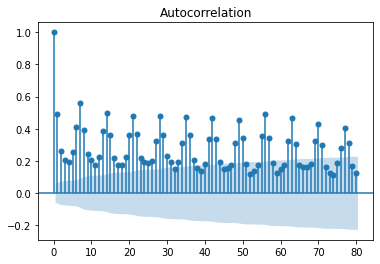

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
a = plot_acf(dataset.cantidad_pasos.values, lags = 80, alpha=.05)
a.figsize=(20,3)

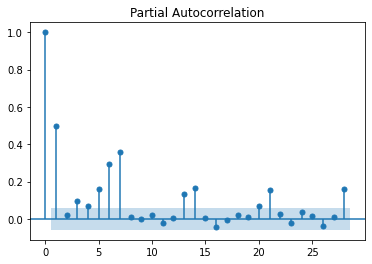

In [61]:
a = plot_pacf(dataset.cantidad_pasos.values, lags = 28, alpha=.05)


Esto confirma en principio lo que vimos anteriormente. 

> Resultados: 
1. Que la serie está altamente correlacionada estacionalmente consigo misma, de manera positiva y significativa (por encima de un Intervalo de confianza del 95%), hasta pasados los 80 dias.
2. Que las correlaciones mas altas se dan en periodos de 7 dias, y sus margenes.
3. La Correlacion Parcial parece sugerir un proceso autorregresivo funcion de 7 dias hacia el pasado. 

#### Seleccion de Atributos Finales
Por lo que procedemos a limpiar y arreglar nuestras nuevas variables. Vamos a tomar las 5 mejores variables identiicadas pro el modelo anterior, al momento, por ahora estas son:

1. `t-7`
2. `t-21`
3. `t-1`
4. `t-14`
5. `t-154`

A esta lista vamos a agregar el marcador encodeado de observacion atípica por `feriado_nacional` y tambien un indicador de `dia_semana` para ver cual es su impacto, y el de los fines de semana, en el modelado, más alla del lag -7 de los valores a ciegas. Luego lo plasmaremos en un Array de 7 columnas, y del mismo largo que el modelo anterior para poder predecir y comparar contra la misma serie  

6. `fl_feriado`
7. `fl_dia_semana`


Text(0.5, 1.0, 'Limpieza de Outliers - Serie Cruda')

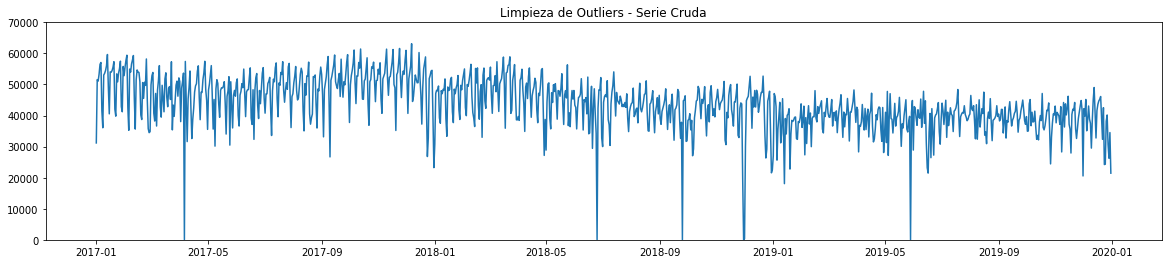

In [62]:
plt.figure(figsize=(20,4)); plt.plot(dataset.cantidad_pasos); plt.ylim((0,70000))
plt.title("Limpieza de Outliers - Serie Cruda")

#### Limpieza de Outliers - No feriados  
Analizamos los outliers de manera clásica, sin ventanas moviles, ni dinamicos, aplicamos criterio estático para definir outliers de la serie por ahora y compararlo con los feriados:

In [63]:
from sklearn.preprocessing import StandardScaler as sc
res = sc().fit_transform(dataset.cantidad_pasos.to_numpy().reshape(-1,1))
filtro = (res > 3) | (res <-3)
dataset[filtro]

,cantidad_pasos,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,
2017-04-06,40,0,0,0,0,1,0,0,0
2018-06-25,0,0,1,0,0,0,0,0,0
2018-09-25,0,0,0,1,0,0,0,0,0
2018-11-30,0,0,0,0,0,0,1,0,0
2018-12-01,350,0,0,0,0,0,0,1,0
2019-01-13,18076,0,0,0,0,0,0,0,1
2019-05-29,0,0,0,0,1,0,0,0,0


Como podemos ver en la siguiente celda, los resultados de outliers no son causados particularmente por feriados:

In [64]:
dataset[filtro].index.isin(feriados)

array([False, False, False, False, False, False, False])

Text(0.5, 1.0, 'Limpieza de Outliers - Serie Interpolada')

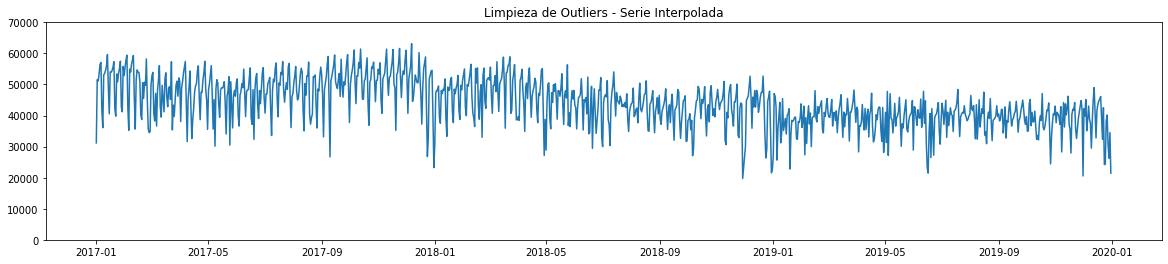

In [65]:
# Relleno con las diferentes metodologías
dataset.loc[filtro.flatten(),'cantidad_pasos'] = np.nan
dataset['cantidad_pasos'] = dataset.cantidad_pasos.interpolate().values
plt.figure(figsize=(20,4)); plt.plot(dataset.cantidad_pasos); plt.ylim((0,70000))
plt.title("Limpieza de Outliers - Serie Interpolada")

#### Creacion de estructuras y filtrado de variables relevantes  
Extraigo y filtro variables destacadas del trabajo anterior y nuevas seleccionadas; fechas relevantes, marcas de feriados y de tipo de dia de la semana

In [66]:
%qtconsole

In [67]:
lookback = 180 # mismo lookback modelo original para compatibiliad y comparacion de series
X = np.zeros((dataset.shape[0]-lookback, 8+5)) # Columnas: 8 categoricas + 5 lags
y = np.zeros((dataset.shape[0] -lookback,)) 
n = X.shape[0]

In [68]:
for i in range(n):
    # Agarrar -1, -7, -14, -21, -154
    X[i,:] = (dataset.fl_feriado.iloc[lookback+i],# marca feriado
    dataset.dia_0.iloc[lookback+i],# marca semana 
    dataset.dia_1.iloc[lookback+i],
    dataset.dia_2.iloc[lookback+i],
    dataset.dia_3.iloc[lookback+i],
    dataset.dia_4.iloc[lookback+i],
    dataset.dia_5.iloc[lookback+i],
    dataset.dia_6.iloc[lookback+i],
    dataset.cantidad_pasos.iloc[lookback-1+i],
    dataset.cantidad_pasos.iloc[lookback-7+i],
    dataset.cantidad_pasos.iloc[lookback-14+i],
    dataset.cantidad_pasos.iloc[lookback-21+i],
    dataset.cantidad_pasos.iloc[lookback-154+i])  # Composicion de Serie
    y[i] = dataset.cantidad_pasos.iloc[lookback+i] # Composicion y objetivo

X_df = pd.DataFrame(X).rename(columns={x:f'dia_{str(x)}'for x in range(1,8)}).rename(columns={0:'fl_feriado', 8:'t-1', 9:'t-7',10:'t-14', 11:'t-21', 12:'t-154'})
col_names = X_df.columns

Voy a separar las variables dummies de las demas para extraer nuevas relaciones polinomicas y escalar

In [69]:
atrs = X[:,-5:]; display(atrs)
dummies = X[:,:-5]; display(dummies)

array([[53626., 53526., 55347., 54965., 57506.],
       [55433., 43183., 39192., 46901., 42831.],
       [45628., 39042., 37147., 39656., 41218.],
       ...,
       [30681., 32337., 32774., 38839., 39500.],
       [26259., 42531., 41588., 37518., 38338.],
       [34523., 24220., 43597., 29518., 38817.]])

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

#### Creacion de relaciones polinomicas y Escalado de variables  

In [70]:
#Creo atributos polinomicos para detectar nuevas relaciones potenciales
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=4, include_bias=False)

poly_atrs = poly.fit_transform(atrs); 
poly_cols = poly.get_feature_names()

# Escalamos los datos para no distorsionar la variabilidad de PCA por las escalas de cada variable
from sklearn.preprocessing import StandardScaler

scaled_poly = StandardScaler().fit_transform(poly_atrs)

______________
#### Creamos funcion de TimeSeries Cross validation - con `Sklearn` 
Ahora que tenemos nuestro dataset con todas nuestras variables creamos una funcion para abstraer el CrossValidation Folding en series de tiempo y realizar los experimentos de manera mas legible:  

In [71]:
# Automatiza el cross validation e impresion de resultados para modelos de regresion
def cross_validation_ts(df, model_object, n_splits=4, figsize=(20,4)):

    from sklearn.metrics import mean_squared_error # para RSME
    from sklearn.model_selection import TimeSeriesSplit # para Indices

    errores = []
    dd = {}

    tss = TimeSeriesSplit(n_splits=n_splits)
    md = model_object

    # devuelve array de numpy
    if isinstance(df, pd.DataFrame):
        X = pd.to_numpy(df)
    elif isinstance(df, np.ndarray):
        X = df
    # Tamaño graficado
    plt.figure(figsize=figsize)
    plt.title(f"Importancias Atributos - Splits:")

    # Crea indices para cortes de Serie de tiempo
    for ix, data_index in enumerate(tss.split(X)):
        train_index, test_index = data_index

        # Muestra Numero de Split + Fronteras de corte
        print(f"TRAIN # {ix}:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]    
        y_train, y_test = y[train_index], y[test_index]

        # Ajusto modelo sobre corte
        md = model_object.fit(X_train,y_train)

        # Prediccion y medicion de errores
        y_test_pred = md.predict(X_test)
        error_split = np.sqrt(mean_squared_error(y_test, y_test_pred))
        errores.append(error_split)

        # Comparacion contra Benchmark (dia anterior):
        benchmark =  y[test_index - 1] # un dia menos para todos los indices
        error_benchmark = np.sqrt(mean_squared_error(y_test, benchmark))

        # Guardo importancias en Dataframes para explorar
        dd[f'Importancias_split_{ix}'] = pd.DataFrame({'IMPORTANCIA':md.feature_importances_ , 'error':error_split})
        dd[f'Errores_split_{ix}'] = error_split

        # Graficado - Feature importances de cada Split
        sns.scatterplot(x=np.arange(md.feature_importances_.size), y=md.feature_importances_, alpha = 0.6, label=f"Split # {ix+1}", s=90)
        plt.xlabel("Atributos"); plt.ylabel("Score - Importancia")

        # Impresion resultados
        print(f"    --> Error Modelo: RMSE: {error_split}")
        print(f"    --> Error Benchmark - Dia anterior: {error_benchmark}")
        print(f"    --> Diferencia = Modelo - Bench : {error_split-error_benchmark}")

    print("\n\n", f"CROSS VALIDATION SCORE: {np.mean(errores)}")
    dd[f'CV_SCORE']=np.mean(errores)

    return dd

_____________
### 3. Experimentos Principales: Entrenamiento y Prediccion - Nuevo modelo   
Vamos a usar exactamente la misma configuracion de modelo de Random Forest que identificamos como optima en el proyecto anterior, para poder realizar una comparacion objetiva repsecto al efecto de los nuevos predictores incorporados al modelo. De esta manera procedemos a entrenar el mismo modelo y predecir sobre los distintos cortes de Cross Validation con Series de Tiempo para ver su efecto promedio sobre el total de los kfolds:

In [72]:
X_new = np.concatenate((dummies, scaled_poly), axis =1)
pd.DataFrame(X_new).tail()

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
910,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.685514,0.379241,...,0.112558,-0.481476,-0.377489,-0.265171,-0.162799,-0.721089,-0.659149,-0.578938,-0.492145,-0.408692
911,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.413771,-0.548562,...,-0.623313,-0.326662,-0.433191,-0.553378,-0.666375,-0.271791,-0.369403,-0.484329,-0.601969,-0.700973
912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.695716,-1.495534,...,-1.026183,-0.836943,-0.877841,-0.907284,-0.916969,-0.706941,-0.731983,-0.754281,-0.772364,-0.777827
913,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.292365,-0.109742,...,-0.674208,-0.729810,-0.757584,-0.779724,-0.790054,-0.816566,-0.847255,-0.869476,-0.881657,-0.875394
914,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.177325,-2.598974,...,-0.543453,-1.146880,-1.075189,-0.926801,-0.709086,-1.272064,-1.255818,-1.175389,-1.033231,-0.836232


TRAIN # 0: (155,) TEST: (152,)
    --> Error Modelo: RMSE: 5470.288818992534
    --> Error Benchmark - Dia anterior: 8039.626963802814
    --> Diferencia = Modelo - Bench : -2569.33814481028
TRAIN # 1: (307,) TEST: (152,)
    --> Error Modelo: RMSE: 3677.4322962236233
    --> Error Benchmark - Dia anterior: 6436.516032107661
    --> Diferencia = Modelo - Bench : -2759.0837358840377
TRAIN # 2: (459,) TEST: (152,)
    --> Error Modelo: RMSE: 5782.973794909491
    --> Error Benchmark - Dia anterior: 6904.859748851948
    --> Diferencia = Modelo - Bench : -1121.8859539424575
TRAIN # 3: (611,) TEST: (152,)
    --> Error Modelo: RMSE: 4712.152261483663
    --> Error Benchmark - Dia anterior: 6459.9680332128255
    --> Diferencia = Modelo - Bench : -1747.8157717291624
TRAIN # 4: (763,) TEST: (152,)
    --> Error Modelo: RMSE: 4446.796345453876
    --> Error Benchmark - Dia anterior: 6239.3188488302485
    --> Diferencia = Modelo - Bench : -1792.5225033763727


 CROSS VALIDATION SCORE: 4817.92

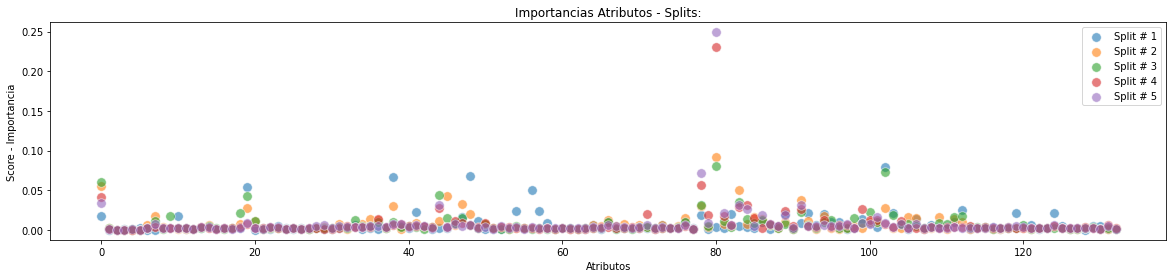

In [73]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1)
results = cross_validation_ts(X_new, rf, n_splits=5, figsize=(20,4))

* Modelo Tp 3 - CV: `RSME: 5136.45`
* Modelo Tp 4 - CV: `RSME: 4817.93` (Variacion de -6.20 %)

> El resultado incial, solo con los nuevos atributos agregados nos devuelve un `RMSE: 4829.26` que reduce el error de sus predicciones en aprox ~ 318.52 viajes promedio (equivalente a un -6.20 % de Error). Es una mejora y podemos ver que en principio los atributos con info de tipo de dia y feriados tienen su efecto para explicar volumen y el modelo, aún con la misma configuracion de modelo. Es una mejora tangible, en terminos de reduccion error, mas que nada teniendo en cuenta lo facil que fue incorporar algo de  informacion extra y obtener resultados, pero no implica una diferencia realmente grande respecto a la base ya lograda.

Ahora seguiremos trabajando el dataset para entender si otras mejoras son posibles. 

#### Descomposicion PCA - Seleccion de Componentes Principales 
Veremos si la realizacion de un PCA permite algun tipo  reduccion de dimensionalidad y ranking de las mismas, descartando dimensiones innecesarias, una seleccion adicional sobre esos atributos polinomicos:

In [74]:
pd.DataFrame(X_new).tail()

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
910,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.685514,0.379241,...,0.112558,-0.481476,-0.377489,-0.265171,-0.162799,-0.721089,-0.659149,-0.578938,-0.492145,-0.408692
911,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.413771,-0.548562,...,-0.623313,-0.326662,-0.433191,-0.553378,-0.666375,-0.271791,-0.369403,-0.484329,-0.601969,-0.700973
912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.695716,-1.495534,...,-1.026183,-0.836943,-0.877841,-0.907284,-0.916969,-0.706941,-0.731983,-0.754281,-0.772364,-0.777827
913,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.292365,-0.109742,...,-0.674208,-0.729810,-0.757584,-0.779724,-0.790054,-0.816566,-0.847255,-0.869476,-0.881657,-0.875394
914,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.177325,-2.598974,...,-0.543453,-1.146880,-1.075189,-0.926801,-0.709086,-1.272064,-1.255818,-1.175389,-1.033231,-0.836232


In [89]:
from sklearn.decomposition import PCA
X_pca = np.concatenate((dummies, scaled_poly), axis =1)
pca = PCA(n_components= int(X_new.shape[1]/3), random_state=1)
X_pca = pca.fit_transform(X_pca) 

In [93]:
# Reducimos todo el dataset a 44 componentes principales
# X = X_pca[:,:]
pd.DataFrame(X_pca).tail()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
910,-2.362070,1.476050,1.872713,-2.739836,-2.150802,-0.324279,-0.060544,0.318168,-0.262901,0.741528,...,0.019007,0.004639,-0.026722,0.005479,0.007767,0.012292,0.009393,-0.007535,0.003908,-0.000391
911,-5.823603,-0.088560,0.845965,0.967370,0.283563,-0.329881,0.293491,-0.023448,-0.039912,0.127106,...,-0.007782,0.009172,0.001268,-0.001014,0.002365,-0.009694,-0.001999,0.000319,-0.002549,-0.000283
912,-12.366727,1.690436,0.233146,1.141677,0.681731,1.128096,-0.028050,-0.026328,0.009448,-0.177853,...,0.008357,-0.015617,0.008145,-0.009670,-0.008206,-0.009452,0.001336,-0.009216,-0.005441,-0.009878
913,-9.796725,3.100492,2.693516,-1.838883,-0.057956,0.183313,0.902231,-0.177843,0.007139,-0.207382,...,0.000451,0.013372,0.006570,-0.017756,0.013248,-0.014979,-0.004106,0.004363,0.022679,0.005350
914,-12.850068,0.572589,-0.024830,0.779988,-3.963183,1.051263,-0.095130,0.723552,0.237379,-0.808359,...,-0.054442,-0.018720,0.001625,-0.011548,-0.015695,0.038362,0.011602,-0.056296,-0.026937,0.020253


#### Nuevo Modelo - RandomForest mejorado 

In [91]:
X_pca

array([[ 2.25049638e+01,  8.81504713e-01, -1.61786134e+00, ...,
        -5.32414425e-03,  2.63352770e-03,  8.61557563e-03],
       [ 1.69109548e+00, -5.80685608e+00, -1.93155053e+00, ...,
        -1.61505038e-02, -7.10069675e-03, -2.54578603e-03],
       [-6.00330960e+00, -2.04184722e+00, -1.18165935e+00, ...,
         1.10662190e-03, -2.56779369e-03,  1.87192923e-03],
       ...,
       [-1.23667272e+01,  1.69043595e+00,  2.33146357e-01, ...,
        -9.21638095e-03, -5.44083131e-03, -9.87782144e-03],
       [-9.79672503e+00,  3.10049195e+00,  2.69351582e+00, ...,
         4.36266267e-03,  2.26786828e-02,  5.34958399e-03],
       [-1.28500684e+01,  5.72588932e-01, -2.48297862e-02, ...,
        -5.62961553e-02, -2.69366770e-02,  2.02526924e-02]])

TRAIN # 0: (155,) TEST: (152,)
    --> Error Modelo: RMSE: 5260.878136699108
    --> Error Benchmark - Dia anterior: 8039.626963802814
    --> Diferencia = Modelo - Bench : -2778.7488271037064
TRAIN # 1: (307,) TEST: (152,)
    --> Error Modelo: RMSE: 4279.389533865229
    --> Error Benchmark - Dia anterior: 6436.516032107661
    --> Diferencia = Modelo - Bench : -2157.126498242432
TRAIN # 2: (459,) TEST: (152,)
    --> Error Modelo: RMSE: 5743.263066862729
    --> Error Benchmark - Dia anterior: 6904.859748851948
    --> Diferencia = Modelo - Bench : -1161.5966819892192
TRAIN # 3: (611,) TEST: (152,)
    --> Error Modelo: RMSE: 4531.312695442781
    --> Error Benchmark - Dia anterior: 6459.9680332128255
    --> Diferencia = Modelo - Bench : -1928.6553377700448
TRAIN # 4: (763,) TEST: (152,)
    --> Error Modelo: RMSE: 4592.596580594378
    --> Error Benchmark - Dia anterior: 6239.3188488302485
    --> Diferencia = Modelo - Bench : -1646.7222682358706


 CROSS VALIDATION SCORE: 4881.48

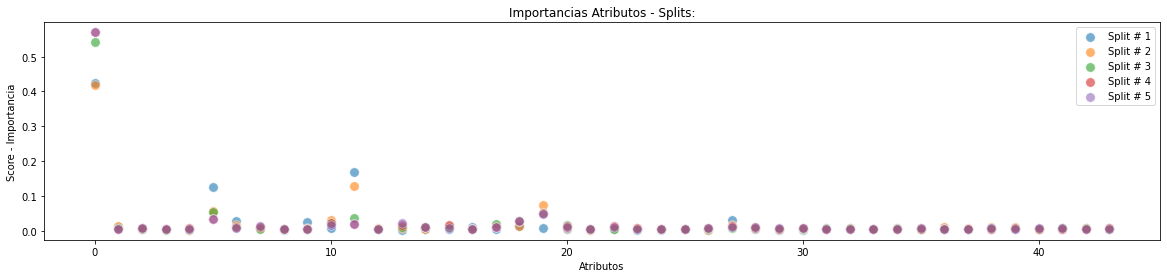

In [92]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1)
# Time Series Cross Validation results
data_result = cross_validation_ts(X_pca, rf, n_splits=5, figsize=(20,4))

<u>_**Nota sobre la validez de Polinomios y PCA en contexto de Series de Tiempo:**_</u>  

Si bien realizamos PCA como experimento para evaluar su impacto, hay que destacar que probablemente la aplicación de `Poliniomios` + `PCA` en este contexto (de Series de Tiempo) pueda llegar a ser algo redundante sin encontrar demasiado beneficio.  

Las Series de Tiempo poseen atributos fuertemente autocorrelacionados (en este caso en el orden de los 7 dias) por ende es esperable que muchos atributos muestren la misma variabilidad sobre el mismo eje, con la misma direccionalidad, sobre todo en estas variables correlacionadas positivamente. En este contexto el efecto del PCA probablemente sea una gran compresion, una gran reduccion de dimensionalidad, a muy pocas variables y ejes relacionados. Como vimos, desde el principio que las variables que elegimos están intimamente correlacionadas, y justamente por eso, probablemente la realización de relaciones polinómicas entre los mismos atributos, y una posterior reduccion via PCA, no nos den informacion extra que podamos rescatar. En este contexto al PCA principalmente nos ayudaría a una gran reduccion de dimensionalidad y eliminacion de redundancia del dataset, de variacion. Hay que tener en cuenta que fue sobre estos propios atributos seleccionados, ya correlacionados entre si, que nosotros calculamos por encima, sus relaciones polinomicas, generando aún más dimensiones y variabilidad sobre los mismos de variabilidad. Lo cual al aplicarle el PCA al final, puede resultar en algo bastante redundante, y que no esperamos que agregue _demasiado valor extra_ por el lado de los polinomios.   

Entendemos que todo este trabajo tendria mas sentido, tal vez, en una instancia anterior a la seleccion de atributos, contando con el dataset completo y todos sus `lags` disponibles, para asi tratar de rescatar alguna interaccion polinomica interesante, de un orden superior al individual, entre lags diferentes, antes justamente de realizar una  compresion via PCA. Aún asi, entendemos que el caso de Series de Tiempo, es bastante particular, y es esperable encontrarse con una gran correlacion entre dimensiones, una redundancia de variabilidad, y la posibilidad de que atributos polinomicos no sumen demasiado.

#### Conclusión:   
El score de este cross validation resulta de `RMSE: 4881.48` y en algunos casos (dependiendo de la cantidad de componentes principales requeridos) si reducimos a muchos menos componentes, el error aumenta, lo cual es esperable, ya que el PCA de la configuracion comprime mas o menos, sobre ejes principales, descartando informacion posiblemente relevante para la precisión del modelo. 

La conclusion que nos llevamos del PCA final es que la cantidad de atributos polinómicos originales puede reducirse a aprox ~ 44 Componentes principales, en este caso, sin demasiado perjuicio en el poder predictivo general, aunque no es lo optimo, y sin ver afectada de manera material su performance, dejando lugar a futuras posibles adiciones de informacion, con un dataset mas reducido, en caso de ser necesario.

#### Resultados finales: 

* Modelo Tp 3 - CV: `RMSE: 5136.45`
* Modelo Mejorado - Tp 4 (Vars + Poly): `RSME: 4817.93`  (Variacion de -6.20 %)
* Modelo Mejorado - Tp 4 (Vars + Poly + PCA): `RMSE: 4881.48` (Variacion de +1.32 %)

#### Modelo Elegido: 

Elegimos el modelo con las variables de `X_new` nuevas variables añadidas + polinomicas generales, sin reduccion, con `RSME: 4817.93` para realizar la comparacion en el conjunto de hold-out final.

In [81]:
pd.DataFrame(X_new).tail()

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
910,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.685514,0.379241,...,0.112558,-0.481476,-0.377489,-0.265171,-0.162799,-0.721089,-0.659149,-0.578938,-0.492145,-0.408692
911,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.413771,-0.548562,...,-0.623313,-0.326662,-0.433191,-0.553378,-0.666375,-0.271791,-0.369403,-0.484329,-0.601969,-0.700973
912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.695716,-1.495534,...,-1.026183,-0.836943,-0.877841,-0.907284,-0.916969,-0.706941,-0.731983,-0.754281,-0.772364,-0.777827
913,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.292365,-0.109742,...,-0.674208,-0.729810,-0.757584,-0.779724,-0.790054,-0.816566,-0.847255,-0.869476,-0.881657,-0.875394
914,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.177325,-2.598974,...,-0.543453,-1.146880,-1.075189,-0.926801,-0.709086,-1.272064,-1.255818,-1.175389,-1.033231,-0.836232


____________________
#### Prediccion - Modelo Final  
Utilizaremos el modelo de X, con todas las variables para ver su desempeño general en la prediccion final.

In [94]:
from sklearn.metrics import mean_squared_error

# Split de Test; Elijo los ultimos 92 dias (ultimo trimestre de 2019 sobre matriz X valida)
dias_a_predecir = 92
X_test = X_new[-dias_a_predecir:] ; y_test = y[-dias_a_predecir:] # inclusivo , dia 92

# Split de Train; fechas anteriores disponibles 
X_train = X_new[:-dias_a_predecir] ; y_train = y[:-dias_a_predecir] # no inclusivo, dia 92

# Entrenamiento 
rf = RandomForestRegressor(n_estimators = 100, random_state=42, n_jobs = -1)
model = rf.fit(X_train, y_train)

# Prediccion 
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# Testeo final
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))


In [95]:
print(f"RMSE train: {rmse_train}")
print(f"RMSE test: {rmse_test}")

RMSE train: 1726.7423076242412
RMSE test: 4896.827724796105


In [96]:
# Benchmark dia anterior
y_benchmark = y[-dias_a_predecir-1:-1]
rmse_benchmark = np.sqrt(mean_squared_error(y_test, y_benchmark ))
print(f"RMSE test benchmark: {np.round(rmse_benchmark, 2)}")

RMSE test benchmark: 6944.76



_**Notas:**_ Queda pendiente explorar y probar si realizando las relaciones polinomiales sobre el dataset origninal, sin filtrar atributos, para luego la realizacion del PCA se descubren algunas relaciones no lineales, de orden superior, interesantes, que puedan mejorar el modelo. La dificultad de ese aproach radica en que el volumen de observaciones disponibles (lookback = fechas pasadas) que generando interacciones polinomicas de hasta orden 4, provocaria miles de nuevos atributos y lo cual lo harian un poco inmanejable para un lookback = 180. 

______________________
#### Resultados trabajo de Variables y Nuevo modelo:   

_- Instancias de Train:_
* Modelo Tp 3 - CV: `RMSE: 5136.45`
* Modelo Mejorado - Tp 4 (Vars + Poly): `RSME: 4817.93`  (Variacion de -6.20 %)
* Modelo Mejorado - Tp 4 (Vars + Poly + PCA): `RMSE: 4881.48` (Variacion de +1.31 %)

_- Instancia de Test final - Conjunto de Hold-out:_  

* Modelo Tp3: `RMSE 5106.20`
* Modelo Tp4 - Nuevos Atributos: `RMSE 4896.83`

> El resultado final de prediccion contra el ultimo trimestre también mejora gracias al trabajo de variables, pasó de `RMSE: 5106.21` en la version anterior a `RMSE 4896.83` en la version mejorada, solamente en conjunto de hold-out final de test (no es cross validation score). Lo cual nos puede indicar que estemos llegando a un cierto limite teorico de lo posible, al menos con este tipo de modelo y la informacion disponible hasta ahora, ya que la mejora no es tan material. 

<br>

### 4. Introduccion y desarrollo de modelos anteriores con PROPHET  

#### 4.1 Introduccion a `Prophet`:  

Prophet es una libreria open-source desarrollada por Facebook, diseñada para desarrollar predicciones y pronósticos sobre Series de Tiempo univariadas o multivariadas (pudiendo agregar nuevos atributos regresores) con el objetivo de lograr predicciones funcionales y precisas de una manera mucho mas escalable y productiva,  facilitando mucho la tarea del proceso de modelado. Escencialmente realiza la eleccion teorica del modelo de manera automática, el ajuste de configuraciones e hiperparámetros, y contiene herramientas y configuraciones para poder ajustar el modelado y realizar tareas como validacion y comparación de resultados y cross validation, tareas que normalmente, y como vimos anteriormente, se realizarían manualmente.

`Prophet` nos permite realizar la misma descomposicion de `modelos aditivos` con series de tiempo de la 3° entrega, permitiendo el mismo analisis original realizado con `StatsModels` de tipo aditivo, para luego analizar los resultantes y también poder realizar pronósticos a futuro con el mismo. Permite la incorporación e identificación de `Tendencia`, y de `Estacionalidad` al modelo, pero también la posibilidad de incorporar regresores extra, como en nuestra lista de mejoras los `Feriados` a sus analisis; con lo cual resulta plenamente compatible con nuestros objetivos de productivización para lograr un modelado de Series de Tiempo mas escalable y productivo.

> _Extracto: "Los ingenieros de Facebook desarrollaron Prophet sobre un backend de STAN, un lenguaje de programación probabilística. Esto le permite hacerse de muchas de las ventajas que ofrece un marco teorico como la estadística Bayesiana de manera mucho mas natural; como la incorporación de estacionalidad, conocimiento específico del ambito de aplicación (problema) y cálculos moviles de intervalos de confianza para una estimación de riesgo basada en datos"_  [Greg Rafferty, 2019 - Forecasting with Facebook Prophet](https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66)

<br> 

#### 4.2 Instalacion de Prophet con Anaconda
<U>*Atención:*</U> _Para poder seguir ejecutando el notebook es 100% necesario instalar apropiadamente `fbprophet`. Esta libreria tiene muchas dependencias y complicaciones a la hora de instalarse, por lo que recomendamos 100% usar Anaconda (y su manejo de dependencias) tal como sugiere [Facebook en su documentacion de instalación](https://facebook.github.io/prophet/docs/installation.html), por lo cual sea naecesario cerrar Jupyter para realizazr la instalacion. Usando Conda como instalador, con los siguientes comandos `conda install gcc`, (si arroja error proseguir), y `conda install -c conda-forge fbprophet` para instalarla desde el repositorio conda-forge._

In [ ]:
# COMANDOS DE INSTALACIÓN via ANACONDA PROMPT
# conda install gcc
# conda install -c conda-forge fbprophet

#### 4.3 Implementacion de Modelo Básico

Prophet permite argumentos que ayudan a configurar el modelo para poder ajustar el modelado al problema que se necesite, incluyendo la posibilidad de incorporar variabels para introducir conocimiento específico sobre el problema y realizar predicciones personalizadas. Permite configurar el tipo de crecimiento _(growth)_ del modelo, el tipo de estacionalidad que se le requiere _(seasonality)_ y más parametros a mano. Sin embargo, inicialmente el modelo intenta ajustar y optimizar todo de manera automática, con los encontrando los mejores parametros posibles para la prediccion. 

La libreria sigue el paradigma de `Sklearn` con un metodo de `.fit()` para realizar el ajuste y uno de `.predict()` para poder realizar la prediccion. 

Para usarlo, es necesario un `DataFrame` que contenga una columna llamada `ds` con la informacion temporal (en formato date-time) y una columna `y` que contenga la informacion objetivo a predecir, las observaciones. Por eso mismo realizaremos una copia y transformaciones, para crear y disponer de este dataframe:

In [289]:
# Dataframe vacio
df = pd.DataFrame()
# Variable objetivo
df['y'] = dataset.cantidad_pasos
# Serie de tiempo
df['ds'] = dataset.index.values
# Regresores de feriado
df['fl_feriado'] = dataset.fl_feriado

for elem in [x for x in dataset.columns if x.startswith("dia")]:
    df[elem] = dataset[elem].values
    
dias_a_predecir = 92 # misma cantidad de periodos que en TP3
base = df[:-92] # Trunco últimos 92 dias para predecir ['2019-10-01':'2019-12-31']
base[['y','ds']].tail()

,y,ds
fecha,,
2019-09-26,43110.0,2019-09-26
2019-09-27,44985.0,2019-09-27
2019-09-28,41925.0,2019-09-28
2019-09-29,38348.0,2019-09-29
2019-09-30,37170.0,2019-09-30


Con esta estructura basica planteada podemos ya salir adelante y plantear nuestro primer modelo.

#### Primer modelo Básico - Input a la libreria:  
Para eso primero cargamos la libreria, es necesario tenerla correctamente instalada, y luego ajustamos con `fit()` un modelo automático, en default, en Prophet sin ningún tipo de parámetro ni trabajo extra:

In [290]:
# Carga de libreria 
import fbprophet
from fbprophet.plot import add_changepoints_to_plot

In [291]:
# Ajusto modelo en default
prophet = fbprophet.Prophet()
prophet.fit(base)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Luego podemos realizar la prediccion de manera adecuada sobre un dataframe vacío con las fechas:

In [292]:
# Realizo prediccion a futuro
futuro = prophet.make_future_dataframe(periods=92)
pronostico = prophet.predict(futuro)

##### Funcionamiento: 
Prophet elije, en default de manera automática, un modelo de mejor ajuste a las observaciones y parámetros que le pasamos. Para poder generar la prediccion debemos crear un Dataframe con las fechas a predecir, y tiene la funcion `make_future_dataframe` ya está preparada para esto y asi tener una columna de fechas, vacías, formato `datetime`, que darle como argumento al `predict()`.

La prediccion realizada nos devolvió el grafico anterior en donde tenemos los siguientes componentes:

> ###### **RESULTADOS Y COMPONENTES PREDICCION**: 
1. Los puntos negros representan cada observacion individual de la serie original.
1. La linea azul es el pronóstico estimado para toda la serie (posterior al ajuste, se estima para todo el tramo completo)
1. La zona celeste, que la rodea, representa los intervalos de confianza, por default al 95%, de manera de inrorporar una medida del riesgo al pronóstico mismo.
1. Finalmente, la linea roja que atraviesa al pronóstico, es la tendencia posterior a la descomposición, definida con una cantidad `n` de grados de libertad configurable vía parámetros.

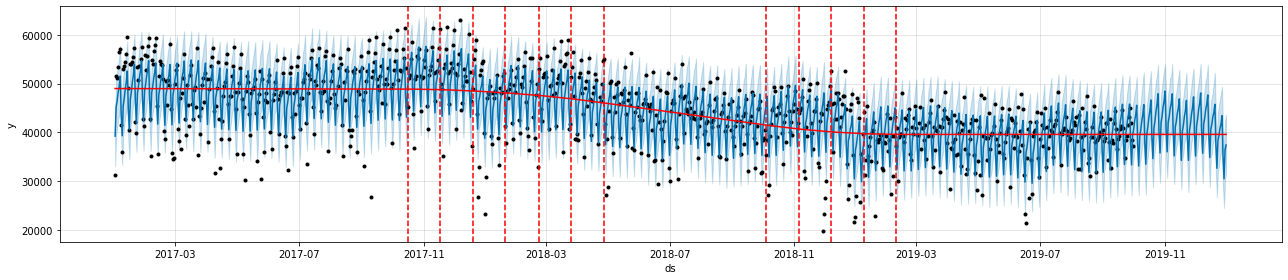

In [293]:
# Ploteo resultados 
fig = prophet.plot(pronostico, figsize=(18,4))
a = add_changepoints_to_plot(fig.gca(), prophet, pronostico)

In [294]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = pronostico.yhat[-92:]
y = dataset.cantidad_pasos[-92:]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Prophet - Modelo #1: {rmse}")

Prophet - Modelo #1: 5985.1327250286895


##### Resultados- Error e Interpretación - Primer modelo Básico:  

* Modelo TP3 (Random Forest): `RMSE =  5,106.20`
* Prophet #1 Modelo: `RMSE: 5,985.13`

Para un primer modelo, extremadamente rapido obtenemos un valor primario de `RMSE: 5,985.13` lo cual, teniendo en cuenta que nuestro modelo de RandomForest original logró un `RMSE: 5,106.20` no es tan bueno, sin embargo hay que entender que el modelo fue realizado de manera completamente automática, sin ningún trabajo de variables extra, ni ninguna configuración adicional al lanzarlo. La facilidad inicial con la cual fue hecho es de considerar.

Por otro lado, si vemos los intervalos de confianza, vemos que la prediccion cubre la mayor parte de las observaciones, en terminos generales, dentro de los mismos. 

Sin embargo, sigue siendo un modelo default básico. Hay mucho espacio para la mejora sabiendo que tenemos que agregar la informacion de los feriados, probablmente clasificados como 'outliers' por el modelo automático, junto con la info del tipo de día.

En el siguiente grafico obtenemos, de manera facil, la descomposición en `Tendencia`, `Estacionalidades`, y `Ruido`  sumado a los regresores extra que agreguemos. Esto nos permite un factor extra de interpretabilidad, en comparacion con la opcion manual de Random forest anterior, muy parecido a la opcion obtenida con `statsmodels`. Es parte de las ventajas de operar con modelos de series de tiempo teoricos puros, que pueden ajustar el modelo a estos parametros teóricos. Esta descomposición nos permite identificar comportamientos importantes para poder responder preguntas y cuestiones de negocio:


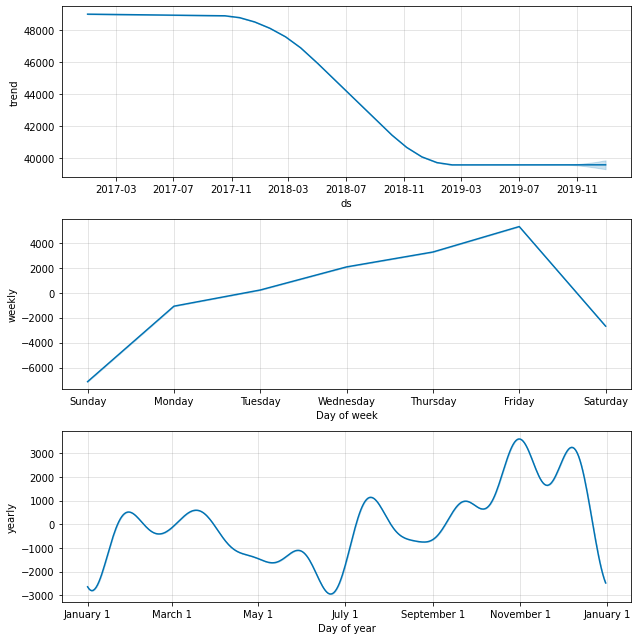

In [295]:
descomp = prophet.plot_components(pronostico, uncertainty=True)

Podemos ver la configuracion de los ajustes encontrados para los componentes del modelo, asi:

In [296]:
prophet.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

Prophet, encontró y ajustó una estacionalidad Anual y Semanal. Esto puede variar en funcion de cada serie y la configuracion que otorgue mejor ajuste, encontrada por Prophet.  

**<u>Composición:</u>** En el grafico, se pueden ver sus aportes por separado:  

- Grafico #1: Tendencia - Movimiento general resultante para toda la serie, neto de las estacionalidades encontradas
- Grafico #2: Estacionalidad Semanal - Movimiento ciclico intra-semanal y su impacto
- Grafico #3: Estacionalidad Anual - Movimiento ciclico intra-anual, y su impacto

La configuracion de la estacionalidad es editable, y es una de las configuraciones manuales e hiperparámetros a tener en cuenta al momento de usar la libreria.

#### 4.4 Modificaciones y Mejoras  
A partir de la configuracion básica, podemos seguir configurando el modelo y ajustarlo. Agregaremos informacion del dominio de aplicacion, los feriados, y todas las mejoras que hablamos anteriormente, tambien con esta libreria para ver su equivalencia.  

Finalmente, podriamos tunear algunos hiperparametros con Validacion Cruzada usando `TimeSeriesCrossValidation` de `sklearn`. Prophet incorpora herramental para realizar controles de performance, cross validation y seleccion de modelos, y ya contiene una funcion llamada `cross_validation` pero no la utilizaremos ya que necesitamos compatibildiad con el trabajo anterior [\[Paper - Prophet - Forecasting at scale\]](https://peerj.com/preprints/3190.pdf)

In [297]:
df.tail()

,y,ds,fl_feriado,dia_0,dia_1,dia_2,dia_3,dia_4,dia_5,dia_6
fecha,,,,,,,,,,
2019-12-27,40182.0,2019-12-27,0,0,0,0,0,1,0,0
2019-12-28,30681.0,2019-12-28,0,0,0,0,0,0,1,0
2019-12-29,26259.0,2019-12-29,0,0,0,0,0,0,0,1
2019-12-30,34523.0,2019-12-30,0,1,0,0,0,0,0,0
2019-12-31,21447.0,2019-12-31,0,0,1,0,0,0,0,0


#### Valores a Predecir  
Necesito agregar al modelo y luego entregarle todos los valores de regresores utilizados para poder predecir:

In [301]:
futuro_2 = df.drop(columns='y')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


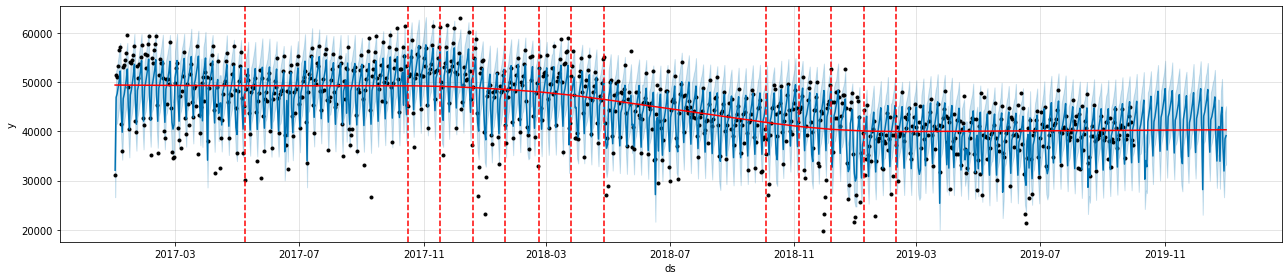

In [302]:
prophet = fbprophet.Prophet()
prophet.add_regressor('fl_feriado')
# prophet.add_regressor('dia_0')
# prophet.add_regressor('dia_1')
# prophet.add_regressor('dia_2')
# prophet.add_regressor('dia_3')
# prophet.add_regressor('dia_4')
# prophet.add_regressor('dia_5')
# prophet.add_regressor('dia_6')
prophet.fit(base)

# Realizo prediccion a futuro
# futuro = prophet.make_future_dataframe(periods=92)
pronostico = prophet.predict(futuro_2)
# Ploteo resutlados 
fig = prophet.plot(pronostico, figsize=(18,4))
a = add_changepoints_to_plot(fig.gca(), prophet, pronostico)

##### RESULTADOS - Adicion de nuevos atributos regresores: 

In [303]:
y_pred = pronostico.yhat[-92:]
y = dataset.cantidad_pasos[-92:]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Prophet - Modelo #2 - RMSE: {rmse}")

Prophet - Modelo #2 - RMSE: 6135.021584950784


Como podemos ver si bien la adicion de informacion de feriados en el modelo original `RandomForest` reducia el error, en este caso no parecemos obtener el mismo resultado, ya que parece ser insensible a esta informacion o no afectar la calibracion del modelo de buena manera. También nos dimos cuenta de lo mismo al agregar los regresores de dias de la semana, ya que Prophet identifica  el componente estacional Intra-semanal (como vimos en la primera descomposición) de manera automatica y agregarlo al ser redundante empeora el modelo y ensucia la descomposicion.  

Si inicialmente en el conjunto de hold-out de test, este error no baja, logramos agregar informacion valida de al modelo, y obtener su calibracion, e informacion de impacto en la descomposición.  Esto es inormacion valiosa de negocio sobre el impacto en el trafico que tienen los feriados y como se comportan , apra poder predecir a futuro y realizar pronósticos. 

Veamos el nuevo resultante de la descomposición:


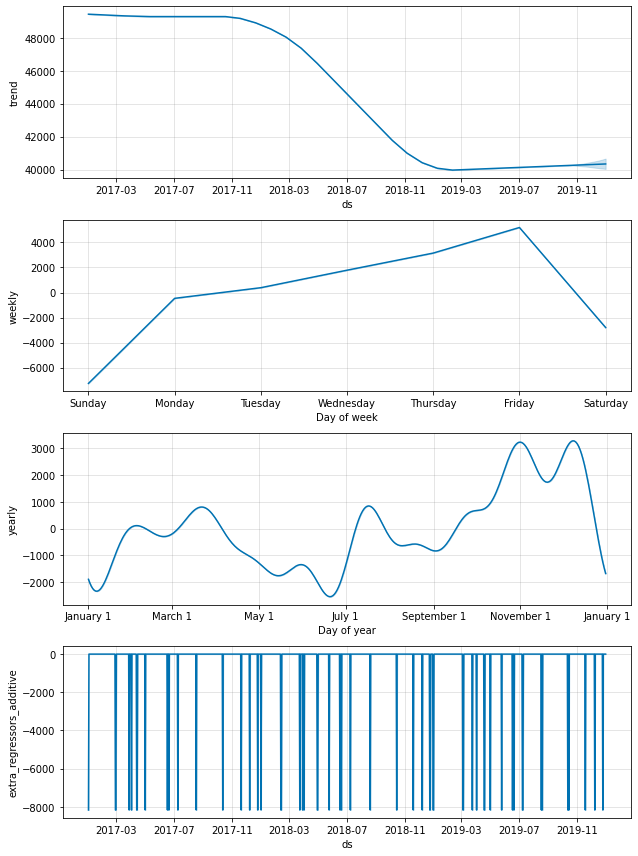

In [304]:
descomp2 = prophet.plot_components(pronostico, uncertainty=True)

En el ultimo grafico `Extra_regressors_additive` vemos la suma de todos los efectos de regresores extra (efecto de `Feriados`+ `Dia_semana`). Por esto mismose ven caidas pronunciadas del orden de los `-6,000 viajes diarios` efecto atribuido por nuestro propio conocimiento a los feriados, mientras que por otro lado vemos una fluctuación repetitiva, de orden estacional, por el efecto de los dias de semana `Dia_semana`, el cual es una fluctuacion estacional, visualizada a nivel de serie completa.  

**Nota:** Sin embargo vemos también que el efecto ya lo calcula la libreria por su cuenta en base a las fechas en datetime y que esto es redundante y no es necesario, de hecho si al mismo fragmento les comentamos los regresores extra de los dias de semana, el error mejora levemente.

Por otro lado, vemos como el modelo funciona prediciendo ciclos apropiadamente, pero tiene cierto grado de error ante comportamientos erraticos que no logra identificar, tal vez cierta insensibilidiad a atributos que no ha identificado y le hacen errar en sus predicciones, en menor medida. Visualizacion de los ultimos 92 dias a predecir y serie original:

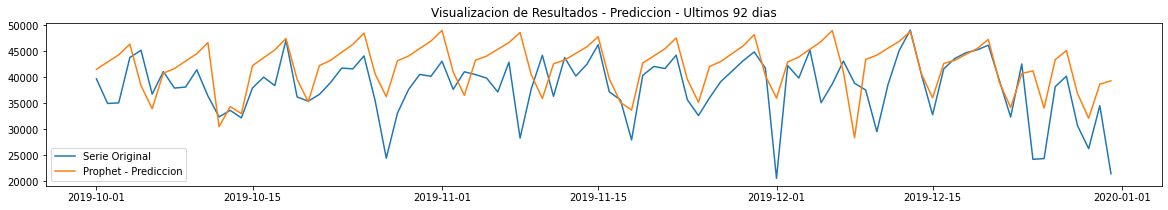

In [283]:
plt.figure(figsize=(20,3))
plt.plot(y.index, y.values, label="Serie Original")
plt.plot(y.index, y_pred, label = "Prophet - Prediccion")
plt.legend()
plt.title("Visualizacion de Resultados - Prediccion - Ultimos 92 dias");

Si bien la serie parece errática en ciertas fechas no encontramos ningún tipo de paro de transporte ni variable exógena extra que pudiera explicar semejantes caidas e ingestar al modelo, por lo que en principio lo atribuiremos a la normalidad y a que el modelo no logra detectar todas las sutilezas posibles a nivel interno. En particular pareciera haber una sobreestimacion de los dias de "mitad de semana", en particular dias `Martes` y `Miercoles` en ciertos puntos.

___________________
#### Optimizacion Modelo Prophet  
Como realizamos en los modelos generalmente, intentamos una optimizacion de los hiperparámetros para lograr una mejor performance del modelo. Sin embargo nos encontramos con que en `Prophet` es algo complicado, ya que elige automáticamente los mejores parámetros en funcion del dataset que se le entregue como input, con lo cual ciertas tareas de cross validation con `Time Series Cross Validation` pueden ser complicadas. Para poder optimizar hiperparametros en Prophet, y que el cross validation tenga sentido, se debe importar la clase de Prophet y forzar su configuracion a mano, anulando asi el automatico (esto dara un error mayor que el que tendriamos en cada corte del CV con el automatico), recien en esa instancia podriamos calibrar los mismos.

Prophet ya tiene su propio metodo de calibrar y hacer cross validation para tuneo de hiperparámetros de manera facil este es: [cross_validation(...)](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)), pero nosotros usaremos `Time Series Split` de `Sklearn` para respetar la compatilidad y poder comparar cada corte y performance directamente con el trabajo anterior. 

Si bien hicimos el experimento, pero es importante recalcar denuevo que lo que validamos fue que efectivamente la libreria encuentra de manera automatica los hiperparámetros optimos para explicar la serie de tiempo, mediante su backend de sampleo en STAN, y el paso de forzado y configuracion manual, no es necesario y probablemente resulte en un CV score con un error mayor que el automático. Solo en caso pulir algun detalle del ajuste, o de la entrada de _conocimiento especifico_ , o algunos regresores o eventos externos a la serie, es necesaria alguna configuracion extra (cosas que la libreria no puede conocer y uno logra, posteriormente ajustar).


Para salvar este problema es que le pedimos de manera explicita que adopte una estacionalidad forzada, tanto a nivel anual como semanal (que son las que queremos reconocer teóricamente para nuestro trabajo) y asi poder tener el mismo modelo en los 4 o 5 Kfolds de Cross Validation que realizemos. Sin embargo hay que tener en cuenta, que el nivel de error del Cross Validation score subirá mucho, en comparacion con el mejor ajustes automatico para cada Kfold.

#### Declaracion de Hiperparametros a ajustar:

In [305]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


Declaracion de funcion para `Time Series Split` en `Prophet`

In [306]:
def cross_validate_prophet(df, all_params, n_splits=5):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error
    
    ################################
    ##### APAGAR NOTIFICACIONES ####
    ################################
    import warnings
    warnings.filterwarnings('ignore')
    ################################
    
    tss = TimeSeriesSplit(n_splits=n_splits)

    # Configuracion
    dd = {}
    cv_scores_wrap = []

    # por cada combinacion de parametros
    for params in all_params: 
        print(f"######################################")
        print(f"// PARAMS // : {params}")
        print(f"######################################")
        
                
        err_test = []
        err_train = []
        
        
        # realizar SPLITS de Cross Validation
        for ix, splits in enumerate(tss.split(df)):

            train_index = splits[0]
            test_index = splits[1]

            X_train = df[train_index[0]:train_index[-1]+1]
            X_test = df[test_index[0]:test_index[-1]+1]

            y_train = df[train_index[0]:train_index[-1]+1].loc[:,'y']
            y_test = df[test_index[0]:test_index[-1]+1].loc[:,'y']

            # Y ajustar Instancia de Prophet con Parametros estacionalidad forzados + **Params a tunear
            dd[f'model_{ix}'] = proph_obj = fbprophet.Prophet(yearly_seasonality=True,daily_seasonality=False, **params).fit(X_train)
            dd["y_pred_"+str(ix)+"_train"] = y_pred_train = proph_obj.predict(X_train)
            dd["y_pred_"+str(ix)+"_test"] = y_pred_test = proph_obj.predict(X_test)
            dd['err_'+str(ix)+"_train"] = y_train - y_pred_train.yhat # diferencial
            dd['err_'+str(ix)+"_test"] = y_test - y_pred_test.yhat
            dd[f'RMSE_train_{str(ix)}'] = RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train.yhat))
            dd[f'RMSE_test_{str(ix)}'] = RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test.yhat))
            print(f"Split {ix}: RMSE_train: {RMSE_train} RMSE_test: {RMSE_test}")

            err_train.append(RMSE_train)
            err_test.append(RMSE_test)
        
        cv_score = np.mean(err_test)
        print(f"   // CV-SCORE: {cv_score} //")
    
        cv_score_param = {}
        cv_score_param['params']= params
        cv_score_param['RMSE'] = cv_score
        cv_scores_wrap.append(cv_score_param)
    
    return cv_scores_wrap


In [307]:
resultados = cross_validate_prophet(df, all_params, n_splits = 5)

######################################
// PARAMS // : {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}
######################################


Split 0: RMSE_train: 4870.468414184062 RMSE_test: 8749.461745985853
Split 1: RMSE_train: 4364.9759651112245 RMSE_test: 5286.908892929174


Split 2: RMSE_train: 4407.71903026371 RMSE_test: 9642.701436508405
Split 3: RMSE_train: 4918.696410575268 RMSE_test: 5417.436003477055


Split 4: RMSE_train: 4991.879425097912 RMSE_test: 4762.616580099045
   // CV-SCORE: 6771.824931799905 //
######################################
// PARAMS // : {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}
######################################


Split 0: RMSE_train: 4313.910812210659 RMSE_test: 5851.171927891597
Split 1: RMSE_train: 4138.405234963546 RMSE_test: 8623.723988489202


Split 2: RMSE_train: 4318.964361848128 RMSE_test: 9599.447039115994
Split 3: RMSE_train: 4868.640438428008 RMSE_test: 5685.189402755411


Split 4: RMSE_train: 4987.175064150618 RMSE_test: 4759.509041858613
   // CV-SCORE: 6903.808280022165 //
######################################
// PARAMS // : {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}
######################################


Split 0: RMSE_train: 4301.9237899271275 RMSE_test: 30254.141623477622
Split 1: RMSE_train: 4138.300964621849 RMSE_test: 8708.783238612625


Split 2: RMSE_train: 4340.592285124339 RMSE_test: 9727.780772172238
Split 3: RMSE_train: 4869.042392052162 RMSE_test: 5707.7476721988505


Split 4: RMSE_train: 4993.731908504516 RMSE_test: 4749.703740577438
   // CV-SCORE: 11829.631409407755 //
######################################
// PARAMS // : {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}
######################################


Split 0: RMSE_train: 4304.415984281255 RMSE_test: 210654.3618834905
Split 1: RMSE_train: 4138.423270709182 RMSE_test: 8591.852221796978


Split 2: RMSE_train: 4305.232998461389 RMSE_test: 9014.545613247223
Split 3: RMSE_train: 4868.6553907887 RMSE_test: 5693.255769863871
Split 4: RMSE_train: 5000.947047891682 RMSE_test: 4770.190795867043
   // CV-SCORE: 47744.84125685312 //
######################################
// PARAMS // : {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
######################################
Split 0: RMSE_train: 4815.601536082265 RMSE_test: 5709.892284011073
Split 1: RMSE_train: 4355.910994683729 RMSE_test: 5064.793119926247
Split 2: RMSE_train: 4378.675195471324 RMSE_test: 8540.462713830275
Split 3: RMSE_train: 4651.059145462299 RMSE_test: 5819.497240349743
Split 4: RMSE_train: 4874.717222633143 RMSE_test: 5081.259956888856
   // CV-SCORE: 6043.181063001239 //
######################################
// PARAMS // : {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
######################################
Split 0: RMSE_train: 4317.708893957389 RMSE_test: 12496.936375772

In [308]:
resultados = pd.DataFrame(resultados).sort_values(by='RMSE'); resultados

,params,RMSE
12,"{'changepoint_prior_scale': 0.5, 'seasonality_...",5899.310701
4,"{'changepoint_prior_scale': 0.01, 'seasonality...",6043.181063
8,"{'changepoint_prior_scale': 0.1, 'seasonality_...",6228.871713
13,"{'changepoint_prior_scale': 0.5, 'seasonality_...",6609.127368
0,"{'changepoint_prior_scale': 0.001, 'seasonalit...",6771.824932
1,"{'changepoint_prior_scale': 0.001, 'seasonalit...",6903.808280
7,"{'changepoint_prior_scale': 0.01, 'seasonality...",8088.947320
5,"{'changepoint_prior_scale': 0.01, 'seasonality...",8142.854071
14,"{'changepoint_prior_scale': 0.5, 'seasonality_...",8182.323324
15,"{'changepoint_prior_scale': 0.5, 'seasonality_...",8267.338363


In [309]:
resultados.head(1).params.values

array([{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}],
      dtype=object)

Prophet - Calibrado #3 - RMSE: 5592.897359869993


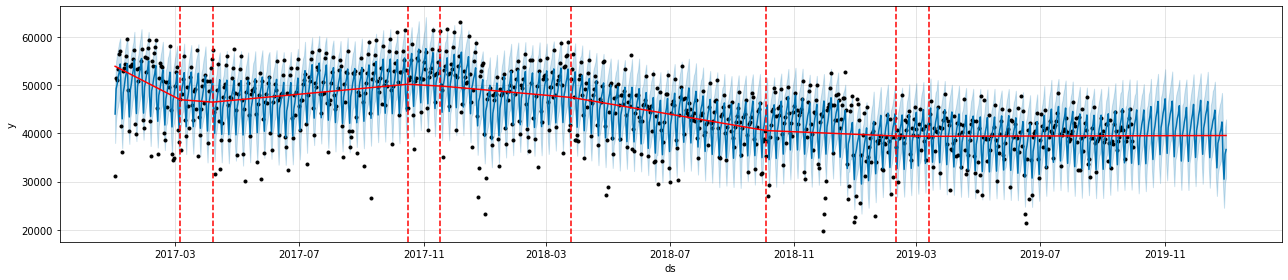

In [311]:
# Dataset
futuro_2 = df.drop(columns='y')
# Agrego nuevos Hiperparametros
prophet = fbprophet.Prophet(yearly_seasonality=True,daily_seasonality=False, changepoint_prior_scale= 0.5, seasonality_prior_scale= 0.01)
prophet.fit(base)
# Realizo prediccion a futuro
pronostico = prophet.predict(futuro_2)

# Ploteo resutlados 
fig = prophet.plot(pronostico, figsize=(18,4))
a = add_changepoints_to_plot(fig.gca(), prophet, pronostico)
y_pred = pronostico.yhat[-92:]
y = dataset.cantidad_pasos[-92:]
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Prophet - Calibrado #3 - RMSE: {rmse}")

#### Resultados finales:  
Como vemos, el resultado del ajuste de estos hiperparámetros (que son algunos de los pocos que Facebook propone como 'posibles' de ajustar) nos da que el mejor RMSE conseguido de manera manual se da con un `RMSE: 5899.31` a lo largo del Cross Validation intertemporal con la siguiente configuracion de `'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01` y si lo ajustamos sobre el segmento de hold-out final conseguimos la siguiente diferencia final 

* Modelo Prophet #1 Basico `RMSE: 5,985.13`
* Modelo Prophet #2 Basico + feriados `RMSE: 6281.23`
* Modelo Prophet #3 Basico + Tuneo de Hiperparametros `RMSE: 5592.89` (-6.55% RSME del primero)

Sin embargo, hay que notar que en la descomposición la tendencia se ve bastante laxa (ya incorpora algo de estacionalidad interanual); por lo que podriamos debatir si es o no correcto, en funcion de nuestros objetivos y elegir uno u otro modelo, pero en principio llegaremos hasta aqui, y ahora haremos foco en el RMSE. Por otro lado, si realizamos las calibraciones de manera automatica, siguiendo los lineamientos de Prophet, en general podemos conseguir una performance bastante buena, y no tan distinta en terminos de error general a ésta (generalmente con  los mismos parametros y los mismos resultados, sin problemas de tendencia) pero de una manera más robusta, escalable y facil. Podemos decir que  Prophet esta diseñado, y calibrado, para operar de manera  automática y solo tiene algunos pocos hiperparámetros para regular (y estos parametros que optimizamos generalmente ya vienen por defecto en una configuracion favorable para la mayor parte de las series de tiempo).   

________________________________________________________
________________________________________________________
####  Conclusión General:   
Pareciera que solo tocando algunos parametros de los enunciados se puede conseguir un extra de precision, pero llegamos, aproximadamente a los mismos resultados. Esta puede ser una de las desventajas de Prophet, como está diseñado para realizar Pronosticos a escala y de manera automatica, la edición manual de ciertos atributos a veces puede interactuar de mala manera con otros parámetros todavia automáticos y se puede tornar dificultosa, o bien, pueden no aportar demasiado.  

Por otro lado, conseguimos en muy pocos pasos un modelo completo, deterministico, con descomposición y conclusiones aplicables al negocio e `insights` sobre el comportamiento de las series de tiempo que nos permiten predecir el futuro de manera estable, escalable y precisa.  Si bien no tiene la performance del algoritmo `RandomForest` un ensamble de arboles con esa profundidad resulta practicamente inexplicable a nivel de negocio, al momento de sacar conclusiones sobre como opera el modelo y realizar exploracion e investigacion sobre los atributos (las reglas numéricas de un RandomForestRegressor son absoutamente inteligibles para traducirlo al problema de negocio). Por otro lado, un modelo de `Prophet` nos otorga un gran control sobre este aspecto, y puede rápidamente ayudarnos a entender los efectos de los distintas componentes, tanto feriados, y otros regresores externos que incorporemos, ayudando a la toma de decisiones sobre Series de Tiempo, y pudiendo calibrar distintos modelos en muy poco tiempo.  

En conlusión, logramos nuestro objetivo de implementar y escalar el analisis de Series de Tiempo, logrando mayor interpretabilidad y una descomposicion teórica de la misma.

________________________________________________________
________________________________________________________


### 4. PROPHET LINKS

#### ARTICULOS INSTRUCTIVOS    
1. [Instructivo basico Series Tiempo- Prophet](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)
1. [Instructivo Detallado - Series de tiempo  - Prophet](https://towardsdatascience.com/facebook-prophet-for-time-series-forecasting-in-python-part1-d9739cc79b1d)
1. [Analitica - Publicidad de instagram - Python Prophet](https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66)

#### MODELOS TEORIA
1. [Time Series Forecasting](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

#### TEORICO/PROGRAMACION
1. [Documentacion - Intro Quickstart](https://facebook.github.io/prophet/docs/quick_start.html)
1. [Prophet Paper presentation - official \[filetype:pdf\]](https://peerj.com/preprints/3190.pdf)
1. [Documentacion - Agregado de Regresores (Variables)](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors)
